## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

There are a number of steps involved in creating an accurate predictive model as described in the project brief. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('ggplot')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [3]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

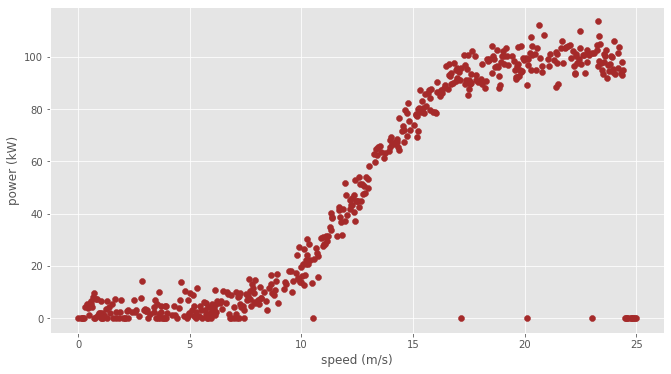

In [5]:
# Plot data on a scatter plot
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o')

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From approximate speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This is something which will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

*Function approximation* is the term used to describe the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to *discrete* output variables (y)" [9], while the output variables for regression models are *continuous* numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3. Regression with `scikit-learn`

***

`scikit-learn` is a machine learning library for the python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` model will be applied to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created below.

### 3.1 Data preparation

***

Before building the first model, it is necessary to prepare the data to maximise the ultimate accuracy of the predictions. Firstly, I use a function to dectect any outliers which may impact the performance of the models. Second, I split the data set into subsets using the *train-test split* procedure.


#### 3.1.1 Outliers

Before applying the linear regression model to the data set, it is important to remove any outliers so that the data we train and test the model on most accurately represents the situation at hand. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13]. As we saw above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

##### Mahalonibis Distance

In researching outlier detection, much of the online resources appeared to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code for the function below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. This function returns a list of index values for the rows containing outliers as detected by the method. I locate these rows using the `pandas.loc` method and remove them from the data set:

In [6]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

# Set variable df to equal pp data set
df = pp

#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [7]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed in the scatterplot. Below, I remove them from the data set, creating an updated data set `pp_clean` in the process:

In [8]:
# Remove outliers from data set
pp_clean = pp.drop(outliers_mahal_rob)

In [9]:
pp_clean.describe()

,speed,power
count,487.000000,487.000000
mean,12.294641,49.296287
std,7.077215,41.409933
min,0.000000,0.000000
25%,6.143500,5.769000
50%,12.337000,44.745000
75%,18.380500,93.733500
max,24.399000,113.556000


<br>




#### 3.1.2 Train-test split

The goal of this project is to accurately predict wind turbine power output from wind speed values. Indeed, it is the aim of any predictive model to maximise the accuracy of model output. In machine learning, *evaluation* and *validation* are key aspects in measuring how accurate a model is in this regard [19]. To ensure that the potential for bias is minimized when evaluating model performance, it is common practice in supervised machine learning to apply the *train-test split* procedure. This involves training a model by splitting the data into subsets. The *train* subset is used to train the model while the *test* subset is held back in order to test the model's accuracy. Given that we already know the output values for the test subset, we can make informed comparisons between the predicted observed values. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [20].) 



<br>

First, the `pp_clean` data set is split by column into two separate subsets, one containing each variable. :

In [10]:
# Create a new dataset containing only values from the speed column
speed_df = pp_clean.drop('power',axis='columns')

#  Print first 10 rows
speed_df.head(10)

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
5,0.325
6,0.400
7,0.450
8,0.501
9,0.526


In [11]:
# Create a new dataset containing only values from the power column
power_df = pp_clean.drop('speed',axis='columns')

# Print first 10 rows
power_df.head(10)

,power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,4.331
6,5.186
7,3.826
8,1.048
9,5.553


<br>

Next, I pass the speed_df and power_df dataframe subsets to `scikit-learn`'s `train_test_split` method and set the parameter *test_size* to 0.5. The test size indicates the size of the train and test sets. Common split percentages include

* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [21]

The values for the train and test subsets are randomly selected, so I set *random_state* to 1. This reproduces the same division of the data each time the program is run. Setting the seed also allows for more representative model comparison as well as parameter comparison when assessing the performance of different models and functions.

In [12]:
# Call train_test_split method on dataframes
A_Train, A_Test, B_Train, B_Test = train_test_split(speed_df, power_df, test_size = 0.2, random_state=1)


<br>

### 3.2 Simple linear regression

***

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [22]. Its equation is often expressed as <br> $$ y = \Theta_0 + \Theta_1x $$ <br> The *powerproduction* data set contains one independent variable (speed) and one dependent variable (power).  function imported from Python's Scikit-learn library to produce a model. Simple linear regression can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set.


#### 3.2.1 Fitting the model

I then create an instance of the `LinearRegression()` class and call the `fit` method, passing the training data as arguments. This will create a simple linear regression model:

In [13]:
# Create an instance of the LinearRegression class
reg = LinearRegression()

# Fit our data to the model
#reg.fit(speed_df, power_df)
reg.fit(A_Train, B_Train)

LinearRegression()

#### Check performance

With the training data now fit to the model, the next step is to use the `score` method to see how well the it is performing. This method calculates the the R-squared value (or coefficient of determination [23]). The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1.0, while a score of 0 or a negative value generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [24] It is worth noting that a high R-squared does not necessarily always indicate the best fit [25].


In [14]:
# Calculate R-squared value
score = reg.score(A_Train, B_Train)

# Print value
print(score)

0.9016673587884961


#### Prediction

Finally, I call the `predict` method on the test data for wind output prediction before plotting this to visualise how well the line fits the data:

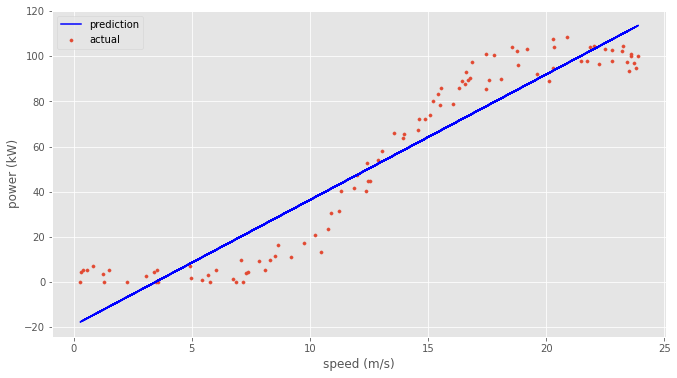

In [15]:
# Use model to make predictions
prediction = reg.predict(A_Test)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, prediction, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

We can see clearly that a straight line does not fit the data very well. For certain predictive models, an R-squared value of ~0.90 might be considered a satisfactory score. However for the current project, it makes sense to attempt to fit a curve to the data to maximise accuracy of predicted output. The following section applies polynomial regression to the data.

#### Outlier vs no outlier
Before moving to the next section, let us briefly create a model with the original data set (prior to outlier removal) in order to demonstrate the impact of dropping outliers from the data set:

In [16]:
# Using original (pp) data set to train model 
speed_df_pp = pp.drop('power',axis='columns')
power_df_pp = pp.drop('speed',axis='columns')

# Train test split
A_Train_pp, A_Test_pp, B_Train_pp, B_Test_pp = train_test_split(speed_df_pp, power_df_pp, test_size = 0.5, random_state=1)

# Create model
reg_pp = LinearRegression()

# Fit model
reg_pp.fit(A_Train_pp, B_Train_pp)

# Calculate R-squared value
score_pp = reg_pp.score(A_Train_pp, B_Train_pp)

# Print score
print(score_pp)

0.7380879260677631


When the model is trained using the original data set, we can see that there is a significant drop in the score. (~0.74 vs ~0.90). This demonstrates the importance of outlier removal, if appropriate.

<br>

### 3.3 Polynomial regression

***

Visualising the plot above, we can see that the straight line does not follow the curve of the data. This is an example of *under-fitting* [26]. In order to overcome this problem, the complexity of the model needs to be increased. With polynomial regression, we can generate a curve that better captures the data. It involves generating a higher order equation by adding powers to convert features into their higher order terms [27]. The equation for polynomial regression is commonly expressed as: $$ y = \Theta_0 + \Theta_1x + \Theta_2x^2 + \Theta_3x^3 + ... + \Theta_nx^n $$ <br>

`scikit-learn` provides the `PolynomialFeatures` class which enables us to transform features to their higher order terms by setting the degree parameter to the desired power. Then, this model can be trained using `LinearRegression` just as above. The code for this is based on an informative towardsdatascience.com blog post [28].

<br>



First, the training data is converted to numpy arrays. This makes it easier to sort and plot below. Then, an instance of the `PolynomialFeatures` class is created, generating polynomial degrees to the 9th degree. This is the degree value that yields the highest R-Squared score. The `fit_transform` method applies polynomial transformation of degree 9. The transformed feature (wind speed) is then fitted to the model and predictions are made based on the test data. 

In [25]:
A_Train2, A_Test2, B_Train2, B_Test2 = train_test_split(pp_clean2.speed, pp_clean2.power, test_size = 0.2, random_state=1)

In [26]:
# Convert train and test subsets to numpy arrays
poly_speed_train = A_Train2.to_numpy().reshape(-1, 1)
poly_power_train = B_Train2.to_numpy().reshape(-1, 1)
poly_speed_test  = A_Test2.to_numpy().reshape(-1, 1)
poly_power_test = B_Test2.to_numpy().reshape(-1, 1)

# Create PolynomialFeatures class instance with degree=9
poly_features = PolynomialFeatures(degree=9)

# Apply polynomial transformation of degree 9
train_speed = poly_features.fit_transform(poly_speed_train)

# Create instance of LinearRegression class
poly_model = LinearRegression()

# Train the model with training data
poly_model.fit(train_speed, poly_power_train)

# Use the model to predict power output of test data
y_test_predict = poly_model.predict(poly_features.fit_transform(poly_speed_test))

In [27]:
# Calculate mean squared error 
mse_test = mean_squared_error(poly_power_test, y_test_predict)

# Calculate coeeficient of determination
r2_test = r2_score(poly_power_test, y_test_predict)

# Output reults to the screen
mse_test, r2_test

(18.30473912370965, 0.9892671550780056)

With an R-Squared value of ~0.99 we can see that polynomial regression performs significantly better than the simple linear regression above.

<br>

When plotted on a graph, it is clear that the curve captures the data much more closely:

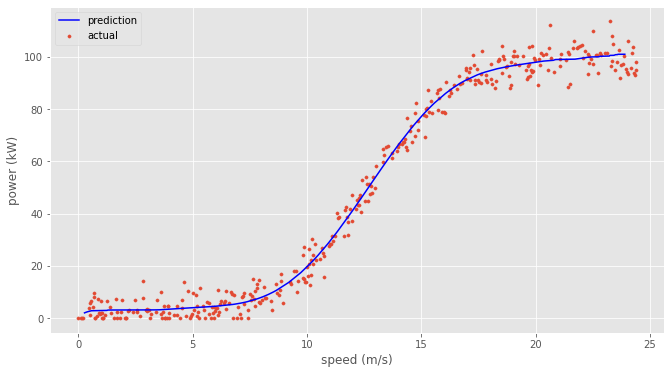

In [28]:
# Plot on scatterplot
plt.scatter(poly_speed_train, poly_power_train, label='actual', s=10)

sorted_poly_speed_test = np.sort(poly_speed_test, 0)
sorted_y_test_predict = np.sort(y_test_predict, 0)


# # Plot line based on model predictions
# plt.plot(sorted_poly_x, sorted_y_test_predict, label='prediction', color='b')
plt.plot(sorted_poly_speed_test, sorted_y_test_predict, label='prediction', color='b')

# Labels
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

In [18]:
B_Train.loc[B_Train['power'] == 0]

,power
208,0.0
39,0.0
89,0.0
73,0.0
111,0.0
16,0.0
0,0.0
105,0.0
70,0.0
42,0.0


In [19]:
B_Test.loc[B_Test['power'] == 0]

,power
67,0.0
31,0.0
4,0.0
47,0.0
65,0.0
135,0.0
110,0.0


In [22]:
pp_clean2.loc[pp_clean2['power'] == 0]

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
15,0.726,0.0
16,0.751,0.0
24,1.026,0.0
26,1.076,0.0
31,1.301,0.0


In [21]:
pp_clean2 = pp_clean.drop([208])

In [23]:
pp_clean3 = pp_clean[pp_clean['power'] != 0] 
pp_clean3.head(10)

,speed,power
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553
10,0.551,6.498
11,0.576,5.241
12,0.626,4.220
13,0.676,7.974
14,0.701,9.746


In [24]:
A_Test.shape

(98, 1)

<br>

Next, I call the `intercept_` method to determine where the line intercepts the y-axis. And below that I use call `coef_` to get the slope of the line. This gives us all the values for formula for the best-fitting line: $$y = mx + b$$ where m is the slope, b is the y-interept and x is the independent variable [3].

[3] dummies.com; How to calculate a regression line; https://www.dummies.com/education/math/statistics/how-to-calculate-a-regression-line/ <br>

In [29]:
# Call the intercept_ method to determine where the line intercepts the y-axis
reg.intercept_

array([-19.1807797])

In [30]:
# Call the coef_ method to calculate the slope of the line
reg.coef_

array([[5.55688005]])

In [31]:
# Set calculated values
m = 4.91759567
x = 9.746
b = -13.899902630519641

y = m*x + b
print(y)

34.02698476930036


As expected, we get the same result for y when we input these values into the formula (above)
<br>



In [32]:
# Calculate R-squared value
reg.score(speed_df, power_df)

0.9009529405175993

<br>


***

In [ ]:
# pp = pp[pp.power != 0]


In [33]:
x = pp['speed']
y = pp['power']

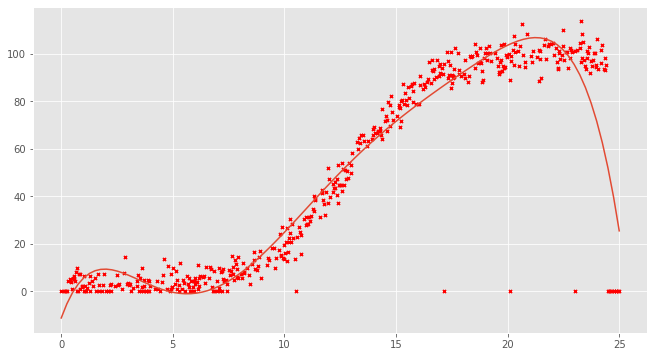

In [34]:
mymodel = np.poly1d(np.polyfit(x, y, 6))

myline = np.linspace(0, 25, 100)

plt.scatter(x, y, color='red', marker='x', s=10)
plt.plot(myline, mymodel(myline))
plt.show()


## Neural network - Regression

***

In [35]:
#pp = pp[pp.power != 0]
#pp.describe()

In [36]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [37]:
model = create_model()

In [38]:


msk = np.random.rand(len(pp_clean2)) < 0.5
train = pp_clean2[msk]

test = pp_clean2[~msk]

In [39]:
model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

Epoch 1/500
24/24 [==============================] - 1s 1ms/step - loss: 3112.7121
Epoch 2/500
24/24 [==============================] - 0s 1ms/step - loss: 1638.2992
Epoch 3/500
24/24 [==============================] - 0s 2ms/step - loss: 467.2621
Epoch 4/500
24/24 [==============================] - 0s 1ms/step - loss: 267.5218
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 275.3210
Epoch 6/500
24/24 [==============================] - 0s 2ms/step - loss: 245.2634
Epoch 7/500
24/24 [==============================] - 0s 2ms/step - loss: 270.3893
Epoch 8/500
24/24 [==============================] - 0s 1ms/step - loss: 262.8914
Epoch 9/500
24/24 [==============================] - 0s 1ms/step - loss: 262.6823
Epoch 10/500
24/24 [==============================] - 0s 1ms/step - loss: 247.1999
Epoch 11/500
24/24 [==============================] - 0s 963us/step - loss: 268.5717
Epoch 12/500
24/24 [==============================] - 0s 1ms/step - loss: 226.5816
Epoch 13/

24/24 [==============================] - 0s 2ms/step - loss: 65.8295
Epoch 101/500
24/24 [==============================] - 0s 1ms/step - loss: 61.8219
Epoch 102/500
24/24 [==============================] - 0s 2ms/step - loss: 67.2537
Epoch 103/500
24/24 [==============================] - 0s 2ms/step - loss: 60.0638
Epoch 104/500
24/24 [==============================] - 0s 1ms/step - loss: 56.8033
Epoch 105/500
24/24 [==============================] - 0s 1ms/step - loss: 60.9134
Epoch 106/500
24/24 [==============================] - 0s 2ms/step - loss: 62.9813
Epoch 107/500
24/24 [==============================] - 0s 1ms/step - loss: 55.7842
Epoch 108/500
24/24 [==============================] - 0s 1ms/step - loss: 52.8964
Epoch 109/500
24/24 [==============================] - 0s 1ms/step - loss: 56.0267
Epoch 110/500
24/24 [==============================] - 0s 2ms/step - loss: 48.1895
Epoch 111/500
24/24 [==============================] - 0s 2ms/step - loss: 61.3237
Epoch 112/500
24/2

24/24 [==============================] - 0s 2ms/step - loss: 34.6009
Epoch 199/500
24/24 [==============================] - 0s 1ms/step - loss: 35.4253
Epoch 200/500
24/24 [==============================] - 0s 2ms/step - loss: 31.7229
Epoch 201/500
24/24 [==============================] - 0s 1ms/step - loss: 33.0895
Epoch 202/500
24/24 [==============================] - 0s 1ms/step - loss: 35.1269
Epoch 203/500
24/24 [==============================] - 0s 1ms/step - loss: 33.2719
Epoch 204/500
24/24 [==============================] - 0s 1ms/step - loss: 37.1213
Epoch 205/500
24/24 [==============================] - 0s 1ms/step - loss: 31.9821
Epoch 206/500
24/24 [==============================] - 0s 1ms/step - loss: 30.9968
Epoch 207/500
24/24 [==============================] - 0s 1ms/step - loss: 32.0105
Epoch 208/500
24/24 [==============================] - 0s 679us/step - loss: 37.8182
Epoch 209/500
24/24 [==============================] - 0s 1ms/step - loss: 33.1894
Epoch 210/500
24

24/24 [==============================] - 0s 2ms/step - loss: 18.7577
Epoch 297/500
24/24 [==============================] - 0s 1ms/step - loss: 16.4242
Epoch 298/500
24/24 [==============================] - 0s 1ms/step - loss: 18.4038
Epoch 299/500
24/24 [==============================] - 0s 679us/step - loss: 17.9525
Epoch 300/500
24/24 [==============================] - 0s 963us/step - loss: 19.0430
Epoch 301/500
24/24 [==============================] - 0s 2ms/step - loss: 25.9325
Epoch 302/500
24/24 [==============================] - 0s 679us/step - loss: 19.3987
Epoch 303/500
24/24 [==============================] - 0s 1ms/step - loss: 19.5367
Epoch 304/500
24/24 [==============================] - 0s 1ms/step - loss: 19.1299
Epoch 305/500
24/24 [==============================] - 0s 1ms/step - loss: 17.9311
Epoch 306/500
24/24 [==============================] - 0s 2ms/step - loss: 21.3705
Epoch 307/500
24/24 [==============================] - 0s 1ms/step - loss: 16.6360
Epoch 308/50

24/24 [==============================] - 0s 1ms/step - loss: 17.5777
Epoch 395/500
24/24 [==============================] - 0s 1ms/step - loss: 17.6693
Epoch 396/500
24/24 [==============================] - 0s 2ms/step - loss: 19.7419
Epoch 397/500
24/24 [==============================] - 0s 1ms/step - loss: 15.9532
Epoch 398/500
24/24 [==============================] - 0s 1ms/step - loss: 18.3564
Epoch 399/500
24/24 [==============================] - 0s 2ms/step - loss: 15.8640
Epoch 400/500
24/24 [==============================] - 0s 1ms/step - loss: 20.1295
Epoch 401/500
24/24 [==============================] - 0s 1ms/step - loss: 16.2180
Epoch 402/500
24/24 [==============================] - 0s 2ms/step - loss: 17.5181
Epoch 403/500
24/24 [==============================] - 0s 1ms/step - loss: 18.9220
Epoch 404/500
24/24 [==============================] - 0s 1ms/step - loss: 20.4663
Epoch 405/500
24/24 [==============================] - 0s 2ms/step - loss: 17.9625
Epoch 406/500
24/2

24/24 [==============================] - 0s 1ms/step - loss: 16.1346
Epoch 493/500
24/24 [==============================] - 0s 1ms/step - loss: 14.6695
Epoch 494/500
24/24 [==============================] - 0s 2ms/step - loss: 18.0448
Epoch 495/500
24/24 [==============================] - 0s 1ms/step - loss: 17.6344
Epoch 496/500
24/24 [==============================] - 0s 1ms/step - loss: 15.4148
Epoch 497/500
24/24 [==============================] - 0s 1ms/step - loss: 19.9090
Epoch 498/500
24/24 [==============================] - 0s 1ms/step - loss: 15.4834
Epoch 499/500
24/24 [==============================] - 0s 1ms/step - loss: 17.8609
Epoch 500/500
24/24 [==============================] - 0s 2ms/step - loss: 17.3147


In [40]:
shapes = model.predict(test['speed'])

In [41]:
shapes.shape

(246, 1)

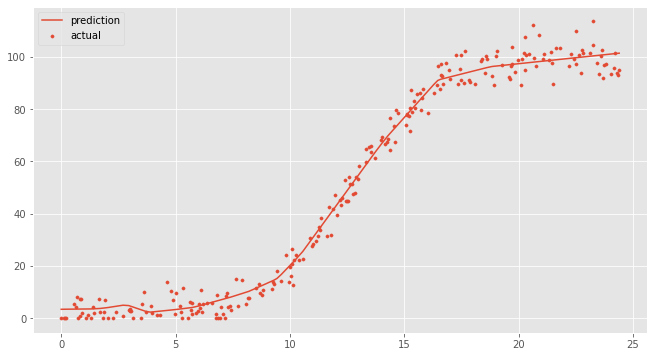

In [43]:
plt.scatter(test['speed'], test['power'], label='actual', s=10)
plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
plt.legend()

In [44]:
model.fit(A_Train, B_Train, epochs=500, batch_size=10)

Epoch 1/500
39/39 [==============================] - 0s 2ms/step - loss: 19.7321
Epoch 2/500
39/39 [==============================] - 0s 2ms/step - loss: 20.3464
Epoch 3/500
39/39 [==============================] - 0s 2ms/step - loss: 20.1132
Epoch 4/500
39/39 [==============================] - 0s 2ms/step - loss: 21.1072
Epoch 5/500
39/39 [==============================] - 0s 2ms/step - loss: 19.9359
Epoch 6/500
39/39 [==============================] - 0s 2ms/step - loss: 20.9877
Epoch 7/500
39/39 [==============================] - 0s 2ms/step - loss: 18.7072
Epoch 8/500
39/39 [==============================] - 0s 2ms/step - loss: 19.2262
Epoch 9/500
39/39 [==============================] - 0s 2ms/step - loss: 19.4936
Epoch 10/500
39/39 [==============================] - 0s 3ms/step - loss: 19.1386
Epoch 11/500
39/39 [==============================] - 0s 2ms/step - loss: 19.4143
Epoch 12/500
39/39 [==============================] - 0s 2ms/step - loss: 20.0942
Epoch 13/500
39/39 [=====

39/39 [==============================] - 0s 3ms/step - loss: 20.7247
Epoch 102/500
39/39 [==============================] - 0s 2ms/step - loss: 19.3496
Epoch 103/500
39/39 [==============================] - 0s 2ms/step - loss: 19.0360
Epoch 104/500
39/39 [==============================] - 0s 2ms/step - loss: 18.7848
Epoch 105/500
39/39 [==============================] - 0s 2ms/step - loss: 19.5341
Epoch 106/500
39/39 [==============================] - 0s 2ms/step - loss: 20.7767
Epoch 107/500
39/39 [==============================] - 0s 2ms/step - loss: 21.6366
Epoch 108/500
39/39 [==============================] - 0s 2ms/step - loss: 20.0484
Epoch 109/500
39/39 [==============================] - 0s 2ms/step - loss: 19.5447
Epoch 110/500
39/39 [==============================] - 0s 2ms/step - loss: 19.7393
Epoch 111/500
39/39 [==============================] - 0s 2ms/step - loss: 18.7903
Epoch 112/500
39/39 [==============================] - 0s 2ms/step - loss: 19.2515
Epoch 113/500
39/3

39/39 [==============================] - 0s 2ms/step - loss: 18.8120
Epoch 200/500
39/39 [==============================] - 0s 2ms/step - loss: 18.5308
Epoch 201/500
39/39 [==============================] - 0s 2ms/step - loss: 19.3647
Epoch 202/500
39/39 [==============================] - 0s 1ms/step - loss: 19.2512
Epoch 203/500
39/39 [==============================] - 0s 2ms/step - loss: 21.5053
Epoch 204/500
39/39 [==============================] - 0s 2ms/step - loss: 19.1139
Epoch 205/500
39/39 [==============================] - 0s 2ms/step - loss: 19.2243
Epoch 206/500
39/39 [==============================] - 0s 2ms/step - loss: 19.1414
Epoch 207/500
39/39 [==============================] - 0s 2ms/step - loss: 18.3072
Epoch 208/500
39/39 [==============================] - 0s 2ms/step - loss: 17.6511
Epoch 209/500
39/39 [==============================] - 0s 2ms/step - loss: 21.6132
Epoch 210/500
39/39 [==============================] - 0s 2ms/step - loss: 20.1675
Epoch 211/500
39/3

39/39 [==============================] - 0s 2ms/step - loss: 18.5664
Epoch 298/500
39/39 [==============================] - 0s 2ms/step - loss: 18.7295
Epoch 299/500
39/39 [==============================] - 0s 2ms/step - loss: 19.4012
Epoch 300/500
39/39 [==============================] - 0s 2ms/step - loss: 21.8804
Epoch 301/500
39/39 [==============================] - 0s 2ms/step - loss: 19.2420
Epoch 302/500
39/39 [==============================] - 0s 2ms/step - loss: 18.8434
Epoch 303/500
39/39 [==============================] - 0s 2ms/step - loss: 18.9010
Epoch 304/500
39/39 [==============================] - 0s 1ms/step - loss: 19.8894
Epoch 305/500
39/39 [==============================] - 0s 2ms/step - loss: 18.5694
Epoch 306/500
39/39 [==============================] - 0s 2ms/step - loss: 18.2071
Epoch 307/500
39/39 [==============================] - 0s 2ms/step - loss: 18.0707
Epoch 308/500
39/39 [==============================] - 0s 2ms/step - loss: 18.4759
Epoch 309/500
39/3

39/39 [==============================] - 0s 2ms/step - loss: 19.5390
Epoch 396/500
39/39 [==============================] - 0s 2ms/step - loss: 18.4332
Epoch 397/500
39/39 [==============================] - 0s 3ms/step - loss: 18.3735
Epoch 398/500
39/39 [==============================] - 0s 2ms/step - loss: 18.1675
Epoch 399/500
39/39 [==============================] - 0s 2ms/step - loss: 19.5570
Epoch 400/500
39/39 [==============================] - 0s 2ms/step - loss: 19.1348
Epoch 401/500
39/39 [==============================] - 0s 2ms/step - loss: 20.1476
Epoch 402/500
39/39 [==============================] - 0s 2ms/step - loss: 18.2743
Epoch 403/500
39/39 [==============================] - 0s 2ms/step - loss: 18.0646
Epoch 404/500
39/39 [==============================] - 0s 2ms/step - loss: 18.3526
Epoch 405/500
39/39 [==============================] - 0s 2ms/step - loss: 19.5625
Epoch 406/500
39/39 [==============================] - 0s 2ms/step - loss: 17.9825
Epoch 407/500
39/3

39/39 [==============================] - 0s 2ms/step - loss: 19.6191
Epoch 494/500
39/39 [==============================] - 0s 2ms/step - loss: 22.2790
Epoch 495/500
39/39 [==============================] - 0s 2ms/step - loss: 18.7092
Epoch 496/500
39/39 [==============================] - 0s 2ms/step - loss: 19.3630
Epoch 497/500
39/39 [==============================] - 0s 2ms/step - loss: 21.4099
Epoch 498/500
39/39 [==============================] - 0s 2ms/step - loss: 20.3626
Epoch 499/500
39/39 [==============================] - 0s 2ms/step - loss: 18.4384
Epoch 500/500
39/39 [==============================] - 0s 2ms/step - loss: 18.5379


In [45]:
nn_predict.shape

NameError: name 'nn_predict' is not defined

In [46]:
arr_sort = np.sort(nn_predict, axis=0)

NameError: name 'nn_predict' is not defined

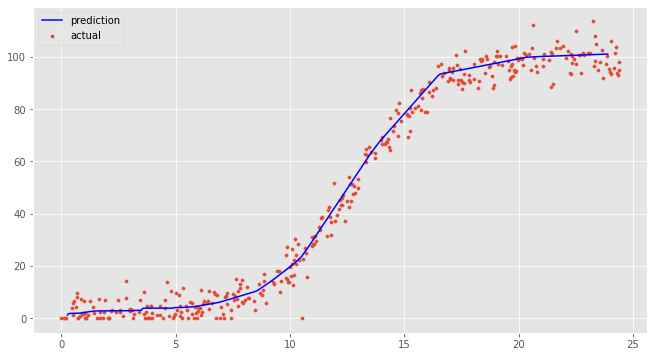

In [50]:
nn_predict = model.predict(A_Test)
nn_predict = np.sort(nn_predict, axis=0)
A_Test_sort = np.sort(A_Test, axis=0)

plt.scatter(A_Train, B_Train, label='actual', s=10)

# sort_axis_nn = operator.itemgetter(0)
# sorted_zip_nn = sorted(zip(A_Test, nn_predict), key=sort_axis)
# sorted_poly_x_nn, sorted_y_test_predict_nn = zip(*sorted_zip)

plt.plot(A_Test_sort, nn_predict, label='prediction', color='b')
plt.legend()

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [52]:
# model.save('my_model.h5')

In [53]:
model.predict([14])

array([[68.347786]], dtype=float32)

In [ ]:
r3_test = r2_score(A_Test, nn_predict)
mse3_test = mean_squared_error(A_Test, nn_predict)

In [ ]:
r3_test, mse3_test

In [68]:
# Regression Example With Boston Dataset: Standardized
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_clean2.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]
# define base model
def baseline_model():
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
	
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=500, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)


Epoch 1/500
44/44 [==============================] - 0s 1ms/step - loss: 4183.1461
Epoch 2/500
44/44 [==============================] - 0s 1ms/step - loss: 3724.9028
Epoch 3/500
44/44 [==============================] - 0s 1ms/step - loss: 2383.2618
Epoch 4/500
44/44 [==============================] - 0s 1ms/step - loss: 493.9715
Epoch 5/500
44/44 [==============================] - 0s 1ms/step - loss: 164.4163
Epoch 6/500
44/44 [==============================] - 0s 1ms/step - loss: 130.2357
Epoch 7/500
44/44 [==============================] - 0s 1ms/step - loss: 107.1224
Epoch 8/500
44/44 [==============================] - 0s 2ms/step - loss: 100.6674
Epoch 9/500
44/44 [==============================] - 0s 2ms/step - loss: 93.0271
Epoch 10/500
44/44 [==============================] - 0s 1ms/step - loss: 74.4688
Epoch 11/500
44/44 [==============================] - 0s 1ms/step - loss: 62.5866
Epoch 12/500
44/44 [==============================] - 0s 1ms/step - loss: 57.0433
Epoch 13/500
4

44/44 [==============================] - 0s 1ms/step - loss: 19.1716
Epoch 101/500
44/44 [==============================] - 0s 1ms/step - loss: 19.1264
Epoch 102/500
44/44 [==============================] - 0s 2ms/step - loss: 17.8057
Epoch 103/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1913
Epoch 104/500
44/44 [==============================] - 0s 830us/step - loss: 18.1425
Epoch 105/500
44/44 [==============================] - 0s 1ms/step - loss: 19.7063
Epoch 106/500
44/44 [==============================] - 0s 1ms/step - loss: 17.7887
Epoch 107/500
44/44 [==============================] - 0s 1ms/step - loss: 18.7614
Epoch 108/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1845
Epoch 109/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8532
Epoch 110/500
44/44 [==============================] - 0s 1ms/step - loss: 20.7195
Epoch 111/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3830
Epoch 112/500
44

44/44 [==============================] - 0s 1ms/step - loss: 17.7912
Epoch 199/500
44/44 [==============================] - 0s 1ms/step - loss: 18.9376
Epoch 200/500
44/44 [==============================] - 0s 1ms/step - loss: 17.3206
Epoch 201/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3688
Epoch 202/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2307
Epoch 203/500
44/44 [==============================] - 0s 2ms/step - loss: 18.0708
Epoch 204/500
44/44 [==============================] - 0s 1ms/step - loss: 17.9893
Epoch 205/500
44/44 [==============================] - 0s 879us/step - loss: 18.0460
Epoch 206/500
44/44 [==============================] - 0s 1ms/step - loss: 15.1330
Epoch 207/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5841
Epoch 208/500
44/44 [==============================] - 0s 1ms/step - loss: 19.6504
Epoch 209/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5425
Epoch 210/500
44

44/44 [==============================] - 0s 2ms/step - loss: 16.1171
Epoch 297/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8410
Epoch 298/500
44/44 [==============================] - 0s 844us/step - loss: 17.1891
Epoch 299/500
44/44 [==============================] - 0s 1ms/step - loss: 17.7938
Epoch 300/500
44/44 [==============================] - 0s 1ms/step - loss: 16.2263
Epoch 301/500
44/44 [==============================] - 0s 2ms/step - loss: 18.8055
Epoch 302/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4314
Epoch 303/500
44/44 [==============================] - 0s 1ms/step - loss: 16.3366
Epoch 304/500
44/44 [==============================] - 0s 1ms/step - loss: 18.9394
Epoch 305/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5021
Epoch 306/500
44/44 [==============================] - 0s 1ms/step - loss: 17.9527
Epoch 307/500
44/44 [==============================] - 0s 2ms/step - loss: 17.6028
Epoch 308/500
44

44/44 [==============================] - 0s 1ms/step - loss: 17.7997
Epoch 395/500
44/44 [==============================] - 0s 1ms/step - loss: 17.3379
Epoch 396/500
44/44 [==============================] - 0s 1ms/step - loss: 19.1031
Epoch 397/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4386
Epoch 398/500
44/44 [==============================] - 0s 1ms/step - loss: 19.0583
Epoch 399/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8608
Epoch 400/500
44/44 [==============================] - 0s 1ms/step - loss: 18.5656
Epoch 401/500
44/44 [==============================] - 0s 1ms/step - loss: 16.6932
Epoch 402/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6774
Epoch 403/500
44/44 [==============================] - 0s 1ms/step - loss: 15.8014
Epoch 404/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7562
Epoch 405/500
44/44 [==============================] - 0s 969us/step - loss: 16.5254
Epoch 406/500
44

44/44 [==============================] - 0s 1ms/step - loss: 16.0280
Epoch 493/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8768
Epoch 494/500
44/44 [==============================] - 0s 1ms/step - loss: 19.2121
Epoch 495/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9113
Epoch 496/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5188
Epoch 497/500
44/44 [==============================] - 0s 1ms/step - loss: 18.0139
Epoch 498/500
44/44 [==============================] - 0s 1ms/step - loss: 18.0080
Epoch 499/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1687
Epoch 500/500
5/5 [==============================] - 0s 0s/step - loss: 8.0802
Epoch 1/500
44/44 [==============================] - 0s 1ms/step - loss: 4458.8919
Epoch 2/500
44/44 [==============================] - 0s 1ms/step - loss: 3687.3792
Epoch 3/500
44/44 [==============================] - 0s 1ms/step - loss: 2855.4086
Epoch 4/500
44/44 [===

Epoch 91/500
44/44 [==============================] - 0s 2ms/step - loss: 19.1883
Epoch 92/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5626
Epoch 93/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1438
Epoch 94/500
44/44 [==============================] - 0s 1ms/step - loss: 20.0927
Epoch 95/500
44/44 [==============================] - 0s 1ms/step - loss: 19.2925
Epoch 96/500
44/44 [==============================] - 0s 1ms/step - loss: 19.5394
Epoch 97/500
44/44 [==============================] - 0s 2ms/step - loss: 17.2640
Epoch 98/500
44/44 [==============================] - 0s 2ms/step - loss: 17.6069
Epoch 99/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4749
Epoch 100/500
44/44 [==============================] - 0s 2ms/step - loss: 17.4319
Epoch 101/500
44/44 [==============================] - ETA: 0s - loss: 26.76 - 0s 1ms/step - loss: 18.5128
Epoch 102/500
44/44 [==============================] - 0s 1ms/step - los

44/44 [==============================] - 0s 1ms/step - loss: 17.4475
Epoch 190/500
44/44 [==============================] - 0s 905us/step - loss: 18.3476
Epoch 191/500
44/44 [==============================] - 0s 1ms/step - loss: 16.6379
Epoch 192/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4425
Epoch 193/500
44/44 [==============================] - 0s 1ms/step - loss: 16.0676
Epoch 194/500
44/44 [==============================] - 0s 1ms/step - loss: 18.6824
Epoch 195/500
44/44 [==============================] - 0s 1ms/step - loss: 18.7133
Epoch 196/500
44/44 [==============================] - 0s 1ms/step - loss: 17.3998
Epoch 197/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9304
Epoch 198/500
44/44 [==============================] - 0s 1ms/step - loss: 19.0739
Epoch 199/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3265
Epoch 200/500
44/44 [==============================] - 0s 1ms/step - loss: 14.9811
Epoch 201/500
44

44/44 [==============================] - 0s 1ms/step - loss: 16.5140
Epoch 288/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7355
Epoch 289/500
44/44 [==============================] - 0s 1ms/step - loss: 18.2378
Epoch 290/500
44/44 [==============================] - 0s 2ms/step - loss: 20.0355
Epoch 291/500
44/44 [==============================] - 0s 878us/step - loss: 16.9408
Epoch 292/500
44/44 [==============================] - 0s 1ms/step - loss: 16.0041
Epoch 293/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2780
Epoch 294/500
44/44 [==============================] - 0s 1ms/step - loss: 17.7536
Epoch 295/500
44/44 [==============================] - 0s 902us/step - loss: 17.2998
Epoch 296/500
44/44 [==============================] - 0s 1ms/step - loss: 15.8200
Epoch 297/500
44/44 [==============================] - 0s 1ms/step - loss: 16.3494
Epoch 298/500
44/44 [==============================] - 0s 2ms/step - loss: 19.0413
Epoch 299/500


44/44 [==============================] - 0s 1ms/step - loss: 17.7887
Epoch 386/500
44/44 [==============================] - 0s 1ms/step - loss: 18.6386
Epoch 387/500
44/44 [==============================] - 0s 1ms/step - loss: 18.2900
Epoch 388/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7318
Epoch 389/500
44/44 [==============================] - 0s 2ms/step - loss: 18.8917
Epoch 390/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3722
Epoch 391/500
44/44 [==============================] - 0s 878us/step - loss: 16.9856
Epoch 392/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1237
Epoch 393/500
44/44 [==============================] - 0s 1ms/step - loss: 17.0010
Epoch 394/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7069
Epoch 395/500
44/44 [==============================] - 0s 1ms/step - loss: 16.3520
Epoch 396/500
44/44 [==============================] - 0s 2ms/step - loss: 19.2563
Epoch 397/500
44

44/44 [==============================] - 0s 1ms/step - loss: 17.5260
Epoch 484/500
44/44 [==============================] - 0s 1ms/step - loss: 16.6979
Epoch 485/500
44/44 [==============================] - 0s 1ms/step - loss: 19.9808
Epoch 486/500
44/44 [==============================] - 0s 2ms/step - loss: 16.1038
Epoch 487/500
44/44 [==============================] - 0s 1ms/step - loss: 19.3124
Epoch 488/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2598
Epoch 489/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1963
Epoch 490/500
44/44 [==============================] - 0s 2ms/step - loss: 17.3077
Epoch 491/500
44/44 [==============================] - 0s 1ms/step - loss: 17.3608
Epoch 492/500
44/44 [==============================] - 0s 1ms/step - loss: 18.2998
Epoch 493/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1876
Epoch 494/500
44/44 [==============================] - 0s 1ms/step - loss: 17.4560
Epoch 495/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 19.8238
Epoch 82/500
44/44 [==============================] - 0s 1ms/step - loss: 17.9368
Epoch 83/500
44/44 [==============================] - 0s 1ms/step - loss: 18.7634
Epoch 84/500
44/44 [==============================] - 0s 1ms/step - loss: 18.6893
Epoch 85/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7131
Epoch 86/500
44/44 [==============================] - 0s 1ms/step - loss: 19.1622
Epoch 87/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3143
Epoch 88/500
44/44 [==============================] - 0s 878us/step - loss: 17.6249
Epoch 89/500
44/44 [==============================] - 0s 1ms/step - loss: 20.3815
Epoch 90/500
44/44 [==============================] - 0s 2ms/step - loss: 17.2029
Epoch 91/500
44/44 [==============================] - 0s 1ms/step - loss: 16.0537
Epoch 92/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1714
Epoch 93/500
44/44 [=======

44/44 [==============================] - 0s 1ms/step - loss: 18.2793
Epoch 180/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7186
Epoch 181/500
44/44 [==============================] - 0s 1ms/step - loss: 19.3038
Epoch 182/500
44/44 [==============================] - 0s 2ms/step - loss: 17.3905
Epoch 183/500
44/44 [==============================] - 0s 2ms/step - loss: 17.3314
Epoch 184/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7066
Epoch 185/500
44/44 [==============================] - 0s 1ms/step - loss: 15.7014
Epoch 186/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8393
Epoch 187/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8632
Epoch 188/500
44/44 [==============================] - 0s 1ms/step - loss: 18.9694
Epoch 189/500
44/44 [==============================] - 0s 1ms/step - loss: 18.6719
Epoch 190/500
44/44 [==============================] - 0s 1ms/step - loss: 17.9633
Epoch 191/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 18.9178
Epoch 278/500
44/44 [==============================] - 0s 1ms/step - loss: 18.7344
Epoch 279/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1691
Epoch 280/500
44/44 [==============================] - 0s 1ms/step - loss: 18.7370
Epoch 281/500
44/44 [==============================] - 0s 1ms/step - loss: 16.6354
Epoch 282/500
44/44 [==============================] - 0s 992us/step - loss: 18.6878
Epoch 283/500
44/44 [==============================] - 0s 1ms/step - loss: 20.1508
Epoch 284/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5900
Epoch 285/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6252
Epoch 286/500
44/44 [==============================] - 0s 1ms/step - loss: 19.5877
Epoch 287/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4971
Epoch 288/500
44/44 [==============================] - ETA: 0s - loss: 16.40 - 0s 2ms/step - loss: 

44/44 [==============================] - 0s 1ms/step - loss: 19.2021
Epoch 376/500
44/44 [==============================] - 0s 1ms/step - loss: 21.0383
Epoch 377/500
44/44 [==============================] - 0s 1ms/step - loss: 16.2984
Epoch 378/500
44/44 [==============================] - 0s 1ms/step - loss: 19.5009
Epoch 379/500
44/44 [==============================] - 0s 995us/step - loss: 18.6923
Epoch 380/500
44/44 [==============================] - 0s 1ms/step - loss: 18.0769
Epoch 381/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4718
Epoch 382/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8192
Epoch 383/500
44/44 [==============================] - 0s 1ms/step - loss: 16.0277
Epoch 384/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7476
Epoch 385/500
44/44 [==============================] - 0s 1ms/step - loss: 18.5488
Epoch 386/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3877
Epoch 387/500
44

44/44 [==============================] - 0s 1ms/step - loss: 16.9427
Epoch 474/500
44/44 [==============================] - 0s 1ms/step - loss: 17.7138
Epoch 475/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7861
Epoch 476/500
44/44 [==============================] - 0s 1ms/step - loss: 15.7672
Epoch 477/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5341
Epoch 478/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6606
Epoch 479/500
44/44 [==============================] - 0s 1ms/step - loss: 18.2151
Epoch 480/500
44/44 [==============================] - 0s 2ms/step - loss: 17.6719
Epoch 481/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8123
Epoch 482/500
44/44 [==============================] - 0s 1ms/step - loss: 15.9251
Epoch 483/500
44/44 [==============================] - 0s 960us/step - loss: 18.1126
Epoch 484/500
44/44 [==============================] - 0s 995us/step - loss: 15.6165
Epoch 485/500


44/44 [==============================] - 0s 2ms/step - loss: 19.2958
Epoch 72/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8736
Epoch 73/500
44/44 [==============================] - 0s 1ms/step - loss: 17.0491
Epoch 74/500
44/44 [==============================] - 0s 1ms/step - loss: 18.5663
Epoch 75/500
44/44 [==============================] - 0s 1ms/step - loss: 15.8141
Epoch 76/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1433
Epoch 77/500
44/44 [==============================] - 0s 1ms/step - loss: 19.3670
Epoch 78/500
44/44 [==============================] - 0s 983us/step - loss: 18.6445
Epoch 79/500
44/44 [==============================] - 0s 2ms/step - loss: 17.8278
Epoch 80/500
44/44 [==============================] - 0s 1ms/step - loss: 16.6344
Epoch 81/500
44/44 [==============================] - 0s 1ms/step - loss: 16.2754
Epoch 82/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1587
Epoch 83/500
44/44 [=======

44/44 [==============================] - 0s 1ms/step - loss: 16.3874
Epoch 170/500
44/44 [==============================] - 0s 1ms/step - loss: 18.5945
Epoch 171/500
44/44 [==============================] - 0s 2ms/step - loss: 17.7712
Epoch 172/500
44/44 [==============================] - 0s 2ms/step - loss: 17.5052
Epoch 173/500
44/44 [==============================] - 0s 1ms/step - loss: 18.2927
Epoch 174/500
44/44 [==============================] - 0s 2ms/step - loss: 17.9515
Epoch 175/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1756
Epoch 176/500
44/44 [==============================] - 0s 1ms/step - loss: 21.3742
Epoch 177/500
44/44 [==============================] - 0s 2ms/step - loss: 16.5946
Epoch 178/500
44/44 [==============================] - 0s 1ms/step - loss: 15.9353
Epoch 179/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1502
Epoch 180/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1402
Epoch 181/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 18.0232
Epoch 268/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5378
Epoch 269/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7409
Epoch 270/500
44/44 [==============================] - 0s 1ms/step - loss: 17.4099
Epoch 271/500
44/44 [==============================] - 0s 867us/step - loss: 18.1403
Epoch 272/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8034
Epoch 273/500
44/44 [==============================] - 0s 1ms/step - loss: 18.0728
Epoch 274/500
44/44 [==============================] - 0s 1ms/step - loss: 19.7825
Epoch 275/500
44/44 [==============================] - 0s 1ms/step - loss: 16.3462
Epoch 276/500
44/44 [==============================] - 0s 2ms/step - loss: 16.7013
Epoch 277/500
44/44 [==============================] - 0s 1ms/step - loss: 17.4301
Epoch 278/500
44/44 [==============================] - 0s 1ms/step - loss: 15.1815
Epoch 279/500
44

44/44 [==============================] - 0s 1ms/step - loss: 15.0430
Epoch 366/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3027
Epoch 367/500
44/44 [==============================] - 0s 2ms/step - loss: 16.5211
Epoch 368/500
44/44 [==============================] - 0s 1ms/step - loss: 20.3810
Epoch 369/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5046
Epoch 370/500
44/44 [==============================] - 0s 1ms/step - loss: 17.3748
Epoch 371/500
44/44 [==============================] - 0s 1ms/step - loss: 19.1956
Epoch 372/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2238
Epoch 373/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1837
Epoch 374/500
44/44 [==============================] - 0s 1ms/step - loss: 15.4952
Epoch 375/500
44/44 [==============================] - 0s 1ms/step - loss: 21.0327
Epoch 376/500
44/44 [==============================] - 0s 1ms/step - loss: 19.4659
Epoch 377/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 18.9978
Epoch 464/500
44/44 [==============================] - 0s 1ms/step - loss: 15.6167
Epoch 465/500
44/44 [==============================] - 0s 1ms/step - loss: 19.3242
Epoch 466/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7038
Epoch 467/500
44/44 [==============================] - 0s 1ms/step - loss: 17.7478
Epoch 468/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9175
Epoch 469/500
44/44 [==============================] - 0s 940us/step - loss: 17.8899
Epoch 470/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8265
Epoch 471/500
44/44 [==============================] - 0s 1ms/step - loss: 15.2417
Epoch 472/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4768
Epoch 473/500
44/44 [==============================] - 0s 940us/step - loss: 17.1947
Epoch 474/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4245
Epoch 475/500


44/44 [==============================] - 0s 2ms/step - loss: 16.1057
Epoch 62/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9974
Epoch 63/500
44/44 [==============================] - 0s 1ms/step - loss: 18.6954
Epoch 64/500
44/44 [==============================] - 0s 2ms/step - loss: 15.1938
Epoch 65/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9644
Epoch 66/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7516
Epoch 67/500
44/44 [==============================] - 0s 2ms/step - loss: 16.6771
Epoch 68/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4145
Epoch 69/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9850
Epoch 70/500
44/44 [==============================] - 0s 1ms/step - loss: 15.8293
Epoch 71/500
44/44 [==============================] - 0s 1ms/step - loss: 16.6039
Epoch 72/500
44/44 [==============================] - 0s 878us/step - loss: 15.3315
Epoch 73/500
44/44 [=======

Epoch 160/500
44/44 [==============================] - 0s 2ms/step - loss: 15.7496
Epoch 161/500
44/44 [==============================] - 0s 1ms/step - loss: 15.2746
Epoch 162/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5799
Epoch 163/500
44/44 [==============================] - 0s 2ms/step - loss: 15.7331
Epoch 164/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8125
Epoch 165/500
44/44 [==============================] - 0s 879us/step - loss: 14.9078
Epoch 166/500
44/44 [==============================] - 0s 1ms/step - loss: 17.4361
Epoch 167/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6710
Epoch 168/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5271
Epoch 169/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5279
Epoch 170/500
44/44 [==============================] - 0s 1ms/step - loss: 14.7275
Epoch 171/500
44/44 [==============================] - 0s 1ms/step - loss: 16.1372
Ep

44/44 [==============================] - 0s 1ms/step - loss: 15.3374
Epoch 259/500
44/44 [==============================] - 0s 1ms/step - loss: 17.9630
Epoch 260/500
44/44 [==============================] - 0s 1ms/step - loss: 17.0450
Epoch 261/500
44/44 [==============================] - 0s 2ms/step - loss: 17.6681
Epoch 262/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1521
Epoch 263/500
44/44 [==============================] - 0s 1ms/step - loss: 15.2455
Epoch 264/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5949
Epoch 265/500
44/44 [==============================] - 0s 1ms/step - loss: 15.2121
Epoch 266/500
44/44 [==============================] - 0s 1ms/step - loss: 18.9839
Epoch 267/500
44/44 [==============================] - 0s 1ms/step - loss: 16.1524
Epoch 268/500
44/44 [==============================] - 0s 1ms/step - loss: 15.6554
Epoch 269/500
44/44 [==============================] - 0s 1ms/step - loss: 15.2937
Epoch 270/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 16.4913
Epoch 357/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2078
Epoch 358/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1980
Epoch 359/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1791
Epoch 360/500
44/44 [==============================] - 0s 1ms/step - loss: 19.1336
Epoch 361/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3097
Epoch 362/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5191
Epoch 363/500
44/44 [==============================] - 0s 932us/step - loss: 15.5509
Epoch 364/500
44/44 [==============================] - 0s 1ms/step - loss: 16.1829
Epoch 365/500
44/44 [==============================] - 0s 1ms/step - loss: 15.9619
Epoch 366/500
44/44 [==============================] - 0s 1ms/step - loss: 15.9944
Epoch 367/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4044
Epoch 368/500
44

44/44 [==============================] - 0s 1ms/step - loss: 13.7216
Epoch 455/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9326
Epoch 456/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5672
Epoch 457/500
44/44 [==============================] - 0s 1ms/step - loss: 17.9220
Epoch 458/500
44/44 [==============================] - 0s 1ms/step - loss: 16.2904
Epoch 459/500
44/44 [==============================] - 0s 1ms/step - loss: 14.6210
Epoch 460/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1730
Epoch 461/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5788
Epoch 462/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2641
Epoch 463/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5738
Epoch 464/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5719
Epoch 465/500
44/44 [==============================] - 0s 2ms/step - loss: 15.7061
Epoch 466/500
44/4

Epoch 52/500
44/44 [==============================] - 0s 2ms/step - loss: 17.4530
Epoch 53/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1268
Epoch 54/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5558
Epoch 55/500
44/44 [==============================] - 0s 1ms/step - loss: 18.6461
Epoch 56/500
44/44 [==============================] - 0s 879us/step - loss: 16.1844
Epoch 57/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4852
Epoch 58/500
44/44 [==============================] - 0s 1ms/step - loss: 18.7417
Epoch 59/500
44/44 [==============================] - 0s 1ms/step - loss: 16.2788
Epoch 60/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7698
Epoch 61/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6588
Epoch 62/500
44/44 [==============================] - 0s 2ms/step - loss: 18.9351
Epoch 63/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8022
Epoch 64/500
4

44/44 [==============================] - 0s 1ms/step - loss: 16.1154
Epoch 152/500
44/44 [==============================] - 0s 1ms/step - loss: 15.6191
Epoch 153/500
44/44 [==============================] - 0s 1ms/step - loss: 17.7589
Epoch 154/500
44/44 [==============================] - 0s 2ms/step - loss: 17.0811
Epoch 155/500
44/44 [==============================] - 0s 1ms/step - loss: 19.8241
Epoch 156/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5733
Epoch 157/500
44/44 [==============================] - 0s 2ms/step - loss: 19.8219
Epoch 158/500
44/44 [==============================] - 0s 1ms/step - loss: 16.3377
Epoch 159/500
44/44 [==============================] - 0s 2ms/step - loss: 16.1071
Epoch 160/500
44/44 [==============================] - 0s 1ms/step - loss: 19.5909
Epoch 161/500
44/44 [==============================] - 0s 1ms/step - loss: 17.3632
Epoch 162/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3828
Epoch 163/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 17.3991
Epoch 250/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8233
Epoch 251/500
44/44 [==============================] - 0s 902us/step - loss: 15.3531
Epoch 252/500
44/44 [==============================] - 0s 1ms/step - loss: 17.0716
Epoch 253/500
44/44 [==============================] - ETA: 0s - loss: 17.50 - 0s 1ms/step - loss: 17.7381
Epoch 254/500
44/44 [==============================] - 0s 1ms/step - loss: 18.7804
Epoch 255/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5585
Epoch 256/500
44/44 [==============================] - 0s 1ms/step - loss: 18.9736
Epoch 257/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3050
Epoch 258/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5630
Epoch 259/500
44/44 [==============================] - 0s 1ms/step - loss: 17.7021
Epoch 260/500
44/44 [==============================] - 0s 1ms/step - loss: 

44/44 [==============================] - 0s 2ms/step - loss: 19.1924
Epoch 348/500
44/44 [==============================] - 0s 2ms/step - loss: 17.7203
Epoch 349/500
44/44 [==============================] - 0s 1ms/step - loss: 18.0821
Epoch 350/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2998
Epoch 351/500
44/44 [==============================] - 0s 1ms/step - loss: 18.7936
Epoch 352/500
44/44 [==============================] - 0s 2ms/step - loss: 18.2035
Epoch 353/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3298
Epoch 354/500
44/44 [==============================] - 0s 1ms/step - loss: 15.9322
Epoch 355/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9887
Epoch 356/500
44/44 [==============================] - 0s 1ms/step - loss: 15.1834
Epoch 357/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5854
Epoch 358/500
44/44 [==============================] - 0s 2ms/step - loss: 18.0763
Epoch 359/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 15.8022
Epoch 446/500
44/44 [==============================] - 0s 1ms/step - loss: 18.8998
Epoch 447/500
44/44 [==============================] - 0s 1ms/step - loss: 15.9273
Epoch 448/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1414
Epoch 449/500
44/44 [==============================] - 0s 2ms/step - loss: 15.7768
Epoch 450/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7664
Epoch 451/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3751
Epoch 452/500
44/44 [==============================] - 0s 2ms/step - loss: 17.4249
Epoch 453/500
44/44 [==============================] - 0s 1ms/step - loss: 16.0106
Epoch 454/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1202
Epoch 455/500
44/44 [==============================] - 0s 2ms/step - loss: 16.0638
Epoch 456/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8159
Epoch 457/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 18.4430
Epoch 44/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6144
Epoch 45/500
44/44 [==============================] - 0s 1ms/step - loss: 19.8604
Epoch 46/500
44/44 [==============================] - 0s 2ms/step - loss: 18.4150
Epoch 47/500
44/44 [==============================] - 0s 2ms/step - loss: 17.5988
Epoch 48/500
44/44 [==============================] - 0s 2ms/step - loss: 16.9864
Epoch 49/500
44/44 [==============================] - 0s 2ms/step - loss: 18.6870
Epoch 50/500
44/44 [==============================] - 0s 917us/step - loss: 21.5504
Epoch 51/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6204
Epoch 52/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1716
Epoch 53/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8945
Epoch 54/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8463
Epoch 55/500
44/44 [=======

44/44 [==============================] - 0s 1ms/step - loss: 16.0580
Epoch 143/500
44/44 [==============================] - 0s 1ms/step - loss: 17.7580
Epoch 144/500
44/44 [==============================] - 0s 1ms/step - loss: 16.6070
Epoch 145/500
44/44 [==============================] - 0s 2ms/step - loss: 16.9310
Epoch 146/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6533
Epoch 147/500
44/44 [==============================] - 0s 1ms/step - loss: 18.2799
Epoch 148/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1235
Epoch 149/500
44/44 [==============================] - 0s 2ms/step - loss: 17.9384
Epoch 150/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8812
Epoch 151/500
44/44 [==============================] - 0s 879us/step - loss: 16.2375
Epoch 152/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8934
Epoch 153/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4087
Epoch 154/500
44

44/44 [==============================] - 0s 1ms/step - loss: 19.3283
Epoch 241/500
44/44 [==============================] - 0s 2ms/step - loss: 18.1747
Epoch 242/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8704
Epoch 243/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9096
Epoch 244/500
44/44 [==============================] - 0s 2ms/step - loss: 16.5923
Epoch 245/500
44/44 [==============================] - 0s 1ms/step - loss: 17.8931
Epoch 246/500
44/44 [==============================] - 0s 1ms/step - loss: 17.9852
Epoch 247/500
44/44 [==============================] - 0s 2ms/step - loss: 19.0237
Epoch 248/500
44/44 [==============================] - 0s 1ms/step - loss: 18.2116
Epoch 249/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4685
Epoch 250/500
44/44 [==============================] - 0s 2ms/step - loss: 16.1680
Epoch 251/500
44/44 [==============================] - 0s 1ms/step - loss: 16.1743
Epoch 252/500
44/4

44/44 [==============================] - 0s 2ms/step - loss: 19.2942
Epoch 339/500
44/44 [==============================] - 0s 2ms/step - loss: 15.3749
Epoch 340/500
44/44 [==============================] - 0s 1ms/step - loss: 17.9907
Epoch 341/500
44/44 [==============================] - 0s 1ms/step - loss: 18.5451
Epoch 342/500
44/44 [==============================] - 0s 1ms/step - loss: 17.3563
Epoch 343/500
44/44 [==============================] - 0s 1ms/step - loss: 19.2231
Epoch 344/500
44/44 [==============================] - 0s 1ms/step - loss: 15.4182
Epoch 345/500
44/44 [==============================] - 0s 1ms/step - loss: 15.6557
Epoch 346/500
44/44 [==============================] - 0s 1ms/step - loss: 17.7552
Epoch 347/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2038
Epoch 348/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8141
Epoch 349/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6701
Epoch 350/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 15.7250
Epoch 437/500
44/44 [==============================] - 0s 1ms/step - loss: 19.0480
Epoch 438/500
44/44 [==============================] - 0s 1ms/step - loss: 18.0130
Epoch 439/500
44/44 [==============================] - 0s 1ms/step - loss: 16.2581
Epoch 440/500
44/44 [==============================] - 0s 2ms/step - loss: 19.1252
Epoch 441/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2826
Epoch 442/500
44/44 [==============================] - 0s 2ms/step - loss: 18.8404
Epoch 443/500
44/44 [==============================] - 0s 1ms/step - loss: 18.4637
Epoch 444/500
44/44 [==============================] - 0s 2ms/step - loss: 16.7593
Epoch 445/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5819
Epoch 446/500
44/44 [==============================] - 0s 1ms/step - loss: 17.6486
Epoch 447/500
44/44 [==============================] - 0s 2ms/step - loss: 14.9073
Epoch 448/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 21.8859
Epoch 35/500
44/44 [==============================] - 0s 1ms/step - loss: 19.0930
Epoch 36/500
44/44 [==============================] - 0s 1ms/step - loss: 21.6595
Epoch 37/500
44/44 [==============================] - 0s 1ms/step - loss: 19.9210
Epoch 38/500
44/44 [==============================] - 0s 2ms/step - loss: 20.3702
Epoch 39/500
44/44 [==============================] - 0s 1ms/step - loss: 18.2615
Epoch 40/500
44/44 [==============================] - 0s 1ms/step - loss: 19.6547
Epoch 41/500
44/44 [==============================] - 0s 1ms/step - loss: 17.4799
Epoch 42/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4196
Epoch 43/500
44/44 [==============================] - 0s 1ms/step - loss: 17.3592
Epoch 44/500
44/44 [==============================] - 0s 1ms/step - loss: 19.5434
Epoch 45/500
44/44 [==============================] - 0s 2ms/step - loss: 18.9013
Epoch 46/500
44/44 [=========

44/44 [==============================] - 0s 1ms/step - loss: 16.3280
Epoch 134/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5236
Epoch 135/500
44/44 [==============================] - 0s 1ms/step - loss: 16.2095
Epoch 136/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4464
Epoch 137/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9789
Epoch 138/500
44/44 [==============================] - 0s 1ms/step - loss: 19.2151
Epoch 139/500
44/44 [==============================] - 0s 1ms/step - loss: 16.7755
Epoch 140/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2842
Epoch 141/500
44/44 [==============================] - 0s 1ms/step - loss: 18.0698
Epoch 142/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5387
Epoch 143/500
44/44 [==============================] - 0s 1ms/step - loss: 17.0553
Epoch 144/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5714
Epoch 145/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 18.9380
Epoch 232/500
44/44 [==============================] - 0s 1ms/step - loss: 15.3299
Epoch 233/500
44/44 [==============================] - 0s 1ms/step - loss: 15.9927
Epoch 234/500
44/44 [==============================] - 0s 1ms/step - loss: 15.4954
Epoch 235/500
44/44 [==============================] - 0s 1ms/step - loss: 16.0031
Epoch 236/500
44/44 [==============================] - 0s 1ms/step - loss: 17.3182
Epoch 237/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2967
Epoch 238/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5344
Epoch 239/500
44/44 [==============================] - 0s 1ms/step - loss: 16.3085
Epoch 240/500
44/44 [==============================] - 0s 1ms/step - loss: 15.5993
Epoch 241/500
44/44 [==============================] - 0s 2ms/step - loss: 16.9448
Epoch 242/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4591
Epoch 243/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 17.7378
Epoch 330/500
44/44 [==============================] - 0s 2ms/step - loss: 14.9051
Epoch 331/500
44/44 [==============================] - 0s 1ms/step - loss: 18.7186
Epoch 332/500
44/44 [==============================] - 0s 1ms/step - loss: 15.4504
Epoch 333/500
44/44 [==============================] - 0s 2ms/step - loss: 17.3966
Epoch 334/500
44/44 [==============================] - 0s 1ms/step - loss: 15.0300
Epoch 335/500
44/44 [==============================] - 0s 2ms/step - loss: 15.9087
Epoch 336/500
44/44 [==============================] - 0s 1ms/step - loss: 15.6051
Epoch 337/500
44/44 [==============================] - 0s 1ms/step - loss: 15.0780
Epoch 338/500
44/44 [==============================] - 0s 2ms/step - loss: 14.9407
Epoch 339/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8861
Epoch 340/500
44/44 [==============================] - 0s 1ms/step - loss: 16.5854
Epoch 341/500
44/4

44/44 [==============================] - 0s 2ms/step - loss: 14.0444
Epoch 428/500
44/44 [==============================] - 0s 1ms/step - loss: 15.9682
Epoch 429/500
44/44 [==============================] - 0s 2ms/step - loss: 15.5602
Epoch 430/500
44/44 [==============================] - 0s 1ms/step - loss: 18.9487
Epoch 431/500
44/44 [==============================] - 0s 2ms/step - loss: 17.1999
Epoch 432/500
44/44 [==============================] - 0s 1ms/step - loss: 15.0654
Epoch 433/500
44/44 [==============================] - 0s 1ms/step - loss: 15.2225
Epoch 434/500
44/44 [==============================] - 0s 2ms/step - loss: 16.4118
Epoch 435/500
44/44 [==============================] - 0s 1ms/step - loss: 14.8084
Epoch 436/500
44/44 [==============================] - 0s 2ms/step - loss: 15.8253
Epoch 437/500
44/44 [==============================] - 0s 2ms/step - loss: 15.6010
Epoch 438/500
44/44 [==============================] - 0s 2ms/step - loss: 16.0741
Epoch 439/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 23.4438
Epoch 25/500
44/44 [==============================] - 0s 1ms/step - loss: 24.5252
Epoch 26/500
44/44 [==============================] - 0s 1ms/step - loss: 22.7588
Epoch 27/500
44/44 [==============================] - 0s 2ms/step - loss: 21.7870
Epoch 28/500
44/44 [==============================] - 0s 1ms/step - loss: 21.3632
Epoch 29/500
44/44 [==============================] - 0s 1ms/step - loss: 20.1996
Epoch 30/500
44/44 [==============================] - 0s 2ms/step - loss: 17.2264
Epoch 31/500
44/44 [==============================] - 0s 2ms/step - loss: 19.0984
Epoch 32/500
44/44 [==============================] - 0s 1ms/step - loss: 20.7524
Epoch 33/500
44/44 [==============================] - 0s 1ms/step - loss: 17.2591
Epoch 34/500
44/44 [==============================] - 0s 2ms/step - loss: 18.2886
Epoch 35/500
44/44 [==============================] - 0s 1ms/step - loss: 17.1515
Epoch 36/500
44/44 [=========

44/44 [==============================] - 0s 1ms/step - loss: 14.0752
Epoch 124/500
44/44 [==============================] - 0s 1ms/step - loss: 16.1955
Epoch 125/500
44/44 [==============================] - 0s 1ms/step - loss: 14.4631
Epoch 126/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4514
Epoch 127/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4656
Epoch 128/500
44/44 [==============================] - 0s 1ms/step - loss: 15.8630
Epoch 129/500
44/44 [==============================] - 0s 1ms/step - loss: 15.6204
Epoch 130/500
44/44 [==============================] - 0s 1ms/step - loss: 16.3836
Epoch 131/500
44/44 [==============================] - 0s 1ms/step - loss: 15.4065
Epoch 132/500
44/44 [==============================] - 0s 1ms/step - loss: 15.4366
Epoch 133/500
44/44 [==============================] - 0s 1ms/step - loss: 18.3419
Epoch 134/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5827
Epoch 135/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 15.5050
Epoch 222/500
44/44 [==============================] - 0s 2ms/step - loss: 17.3011
Epoch 223/500
44/44 [==============================] - 0s 2ms/step - loss: 15.8980
Epoch 224/500
44/44 [==============================] - 0s 1ms/step - loss: 16.1876
Epoch 225/500
44/44 [==============================] - 0s 1ms/step - loss: 15.9075
Epoch 226/500
44/44 [==============================] - 0s 1ms/step - loss: 14.9412
Epoch 227/500
44/44 [==============================] - 0s 1ms/step - loss: 14.7841
Epoch 228/500
44/44 [==============================] - 0s 2ms/step - loss: 16.0120
Epoch 229/500
44/44 [==============================] - 0s 2ms/step - loss: 17.0477
Epoch 230/500
44/44 [==============================] - 0s 2ms/step - loss: 18.7220
Epoch 231/500
44/44 [==============================] - 0s 2ms/step - loss: 14.9007
Epoch 232/500
44/44 [==============================] - 0s 1ms/step - loss: 15.1670
Epoch 233/500
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.9431
Epoch 320/500
44/44 [==============================] - 0s 2ms/step - loss: 17.8303
Epoch 321/500
44/44 [==============================] - 0s 2ms/step - loss: 15.3243
Epoch 322/500
44/44 [==============================] - 0s 2ms/step - loss: 17.1311
Epoch 323/500
44/44 [==============================] - 0s 2ms/step - loss: 14.6035
Epoch 324/500
44/44 [==============================] - 0s 2ms/step - loss: 16.0209
Epoch 325/500
44/44 [==============================] - 0s 2ms/step - loss: 15.9637
Epoch 326/500
44/44 [==============================] - 0s 2ms/step - loss: 17.2933
Epoch 327/500
44/44 [==============================] - 0s 1ms/step - loss: 14.2926
Epoch 328/500
44/44 [==============================] - 0s 1ms/step - loss: 18.0100
Epoch 329/500
44/44 [==============================] - 0s 2ms/step - loss: 14.4814
Epoch 330/500
44/44 [==============================] - 0s 2ms/step - loss: 15.7106
Epoch 331/500
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.9563
Epoch 418/500
44/44 [==============================] - 0s 2ms/step - loss: 16.8641
Epoch 419/500
44/44 [==============================] - 0s 2ms/step - loss: 15.2327
Epoch 420/500
44/44 [==============================] - 0s 2ms/step - loss: 16.4669
Epoch 421/500
44/44 [==============================] - 0s 2ms/step - loss: 15.8963
Epoch 422/500
44/44 [==============================] - 0s 1ms/step - loss: 14.6564
Epoch 423/500
44/44 [==============================] - 0s 2ms/step - loss: 16.0682
Epoch 424/500
44/44 [==============================] - 0s 1ms/step - loss: 16.4327
Epoch 425/500
44/44 [==============================] - 0s 2ms/step - loss: 16.6223
Epoch 426/500
44/44 [==============================] - 0s 1ms/step - loss: 15.4903
Epoch 427/500
44/44 [==============================] - 0s 2ms/step - loss: 15.6812
Epoch 428/500
44/44 [==============================] - 0s 1ms/step - loss: 16.2845
Epoch 429/500
44/4

44/44 [==============================] - 0s 2ms/step - loss: 30.1519
Epoch 16/500
44/44 [==============================] - 0s 2ms/step - loss: 36.8881
Epoch 17/500
44/44 [==============================] - 0s 2ms/step - loss: 29.8224
Epoch 18/500
44/44 [==============================] - 0s 1ms/step - loss: 30.8089
Epoch 19/500
44/44 [==============================] - 0s 2ms/step - loss: 34.7288
Epoch 20/500
44/44 [==============================] - 0s 2ms/step - loss: 32.4955
Epoch 21/500
44/44 [==============================] - 0s 1ms/step - loss: 29.1691
Epoch 22/500
44/44 [==============================] - 0s 2ms/step - loss: 29.5016
Epoch 23/500
44/44 [==============================] - 0s 2ms/step - loss: 25.0238
Epoch 24/500
44/44 [==============================] - 0s 2ms/step - loss: 25.1504
Epoch 25/500
44/44 [==============================] - 0s 2ms/step - loss: 24.5376
Epoch 26/500
44/44 [==============================] - 0s 2ms/step - loss: 25.5412
Epoch 27/500
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 14.7211
Epoch 115/500
44/44 [==============================] - 0s 1ms/step - loss: 17.4855
Epoch 116/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1372
Epoch 117/500
44/44 [==============================] - 0s 1ms/step - loss: 15.3365
Epoch 118/500
44/44 [==============================] - 0s 1ms/step - loss: 16.2749
Epoch 119/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5440
Epoch 120/500
44/44 [==============================] - 0s 1ms/step - loss: 16.1386
Epoch 121/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8805
Epoch 122/500
44/44 [==============================] - 0s 2ms/step - loss: 15.7935
Epoch 123/500
44/44 [==============================] - 0s 1ms/step - loss: 18.1340
Epoch 124/500
44/44 [==============================] - 0s 2ms/step - loss: 15.3494
Epoch 125/500
44/44 [==============================] - 0s 1ms/step - loss: 16.0366
Epoch 126/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 16.3204
Epoch 213/500
44/44 [==============================] - 0s 1ms/step - loss: 17.5979
Epoch 214/500
44/44 [==============================] - 0s 2ms/step - loss: 14.8063
Epoch 215/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9318
Epoch 216/500
44/44 [==============================] - 0s 1ms/step - loss: 16.6784
Epoch 217/500
44/44 [==============================] - 0s 2ms/step - loss: 16.3712
Epoch 218/500
44/44 [==============================] - 0s 1ms/step - loss: 16.6303
Epoch 219/500
44/44 [==============================] - 0s 1ms/step - loss: 14.4495
Epoch 220/500
44/44 [==============================] - 0s 1ms/step - loss: 16.8052
Epoch 221/500
44/44 [==============================] - 0s 1ms/step - loss: 16.1710
Epoch 222/500
44/44 [==============================] - 0s 2ms/step - loss: 15.2517
Epoch 223/500
44/44 [==============================] - 0s 1ms/step - loss: 17.0297
Epoch 224/500
44/4

44/44 [==============================] - 0s 1ms/step - loss: 16.6041
Epoch 311/500
44/44 [==============================] - 0s 2ms/step - loss: 17.3400
Epoch 312/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9154
Epoch 313/500
44/44 [==============================] - 0s 2ms/step - loss: 17.3898
Epoch 314/500
44/44 [==============================] - 0s 878us/step - loss: 16.1349
Epoch 315/500
44/44 [==============================] - 0s 1ms/step - loss: 15.4123
Epoch 316/500
44/44 [==============================] - 0s 1ms/step - loss: 14.1394
Epoch 317/500
44/44 [==============================] - 0s 1ms/step - loss: 16.9547
Epoch 318/500
44/44 [==============================] - 0s 905us/step - loss: 16.7082
Epoch 319/500
44/44 [==============================] - 0s 1ms/step - loss: 14.3606
Epoch 320/500
44/44 [==============================] - 0s 1ms/step - loss: 16.0864
Epoch 321/500
44/44 [==============================] - 0s 1ms/step - loss: 15.2957
Epoch 322/500


44/44 [==============================] - 0s 1ms/step - loss: 15.7222
Epoch 409/500
44/44 [==============================] - 0s 2ms/step - loss: 15.8042
Epoch 410/500
44/44 [==============================] - 0s 1ms/step - loss: 15.6963
Epoch 411/500
44/44 [==============================] - 0s 2ms/step - loss: 15.8142
Epoch 412/500
44/44 [==============================] - 0s 1ms/step - loss: 14.6338
Epoch 413/500
44/44 [==============================] - 0s 2ms/step - loss: 15.7125
Epoch 414/500
44/44 [==============================] - 0s 961us/step - loss: 15.9548
Epoch 415/500
44/44 [==============================] - 0s 1ms/step - loss: 15.3866
Epoch 416/500
44/44 [==============================] - 0s 1ms/step - loss: 15.0940
Epoch 417/500
44/44 [==============================] - 0s 2ms/step - loss: 14.3951
Epoch 418/500
44/44 [==============================] - 0s 1ms/step - loss: 14.6409
Epoch 419/500
44/44 [==============================] - 0s 2ms/step - loss: 14.9649
Epoch 420/500
44

In [65]:
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -23.87 (11.29) MSE


In [67]:
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -52.63 (38.21) MSE


In [69]:
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -21.36 (9.09) MSE


In [59]:
len(X)

486

In [ ]:
ep_100 = 25
ep_500_10 = 23.87

In [ ]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] realpython.com; Split Your Dataset With scikit-learn's train_test_split(); https://realpython.com/train-test-split-python-data/ <br>
[14] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[15] *Ibid* <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[18] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[19] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[20] *Ibid* <br>
[21] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[22] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[23] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[24] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[25] *Ibid* <br>
[26] Agarwal, A.; Polynomial Regression; https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 <br>
[27] *Ibid* <br>
[28] *Ibid* <br>